In [42]:
import numpy as np
import cv2 
import os
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.utils.vis_utils import plot_model
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array



In [3]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [27]:
inputimg = keras.Input(shape=(96,96,1), name="original_img")
x = Conv2D(32, (3, 3), padding='same',  activation='relu', name='conv_1_3x3/1', kernel_initializer=kernel_init, bias_initializer=bias_init)(inputimg)
x = MaxPool2D((3, 3), padding='same',  name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
x=BatchNormalization()(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=64,
                     filters_3x3=128,
                     filters_5x5_reduce=128,
                     filters_5x5=246,
                     filters_pool_proj=64,
                     name='inception_3a')


x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x=BatchNormalization()(x)




x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)


x = Dense(1024, activation='relu', name='dense_540')(x)
x = Dropout(0.3)(x)
x = Dense(540, activation='relu', name='dense_540b')(x)
x = Dropout(0.3)(x)
x = Dense(240, activation='relu', name='dense_240')(x)
x = Dense(30, name='dense_30')(x)

In [28]:
Model = keras.Model(inputimg, x, name='Gaurvendra_Singh')

In [29]:
Model.summary()

Model: "Gaurvendra_Singh"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_img (InputLayer)       (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv_1_3x3/1 (Conv2D)           (None, 96, 96, 32)   320         original_img[0][0]               
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 32, 32, 32)   0           conv_1_3x3/1[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 32, 32, 64)   2112        max_pool_1_3x3/2[0][0]           
___________________________________________________________________________________

In [34]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
Model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=["accuracy"]
)


In [8]:
X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))

Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)


In [35]:
Model.fit(X_train, y_train, validation_split=0.2, epochs=60, batch_size=32, verbose=1)


Train on 1712 samples, validate on 428 samples
Epoch 1/60
1712/1712 [==============================] - 17s 10ms/step - loss: 1.1168 - accuracy: 0.4942 - val_loss: 21.4876 - val_accuracy: 0.4322
Epoch 2/60
1712/1712 [==============================] - 16s 10ms/step - loss: 0.0085 - accuracy: 0.7704 - val_loss: 1.7906 - val_accuracy: 0.4322
Epoch 3/60
1712/1712 [==============================] - 17s 10ms/step - loss: 0.0068 - accuracy: 0.7734 - val_loss: 0.0405 - val_accuracy: 0.4322
Epoch 4/60
1712/1712 [==============================] - 16s 9ms/step - loss: 0.0053 - accuracy: 0.7728 - val_loss: 0.0098 - val_accuracy: 0.4322
Epoch 5/60
1712/1712 [==============================] - 16s 9ms/step - loss: 0.0040 - accuracy: 0.7722 - val_loss: 0.0078 - val_accuracy: 0.4322
Epoch 6/60
1712/1712 [==============================] - 16s 9ms/step - loss: 0.0039 - accuracy: 0.7728 - val_loss: 0.0078 - val_accuracy: 0.4322
Epoch 7/60
1712/1712 [==============================] - 16s 10ms/step - loss: 0

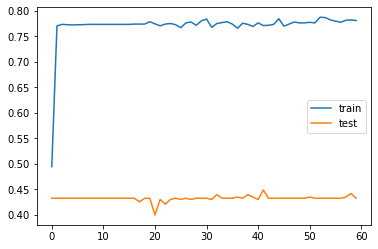

c:\users\gaurvendra\desktop\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [36]:
plt.plot(Model.history.history['accuracy'], label='train')
plt.plot(Model.history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
Model.save("face_keypoints.h5")

In [43]:
from keras.models import load_model
model = load_model('face_keypoints.h5')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [44]:

def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# cap = cv2.VideoCapture(0)


cap = cv2.VideoCapture("https://192.168.43.1:8080/video")
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter("output_filename.avi", fourcc, 20.0, (width, height))


frame_no = 0
while cap.isOpened():

   
    
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)
            # cv2.line(frame, last_point, tuple(point), (0,0,255), thickness=1)
            # cv2.putText(overlay, str(i), tuple(point), 1, 1, (255, 255, 255))

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)


        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)

        out.write(frame)
        cv2.imshow('frame',frame)
      
        

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()
